# Fit biphasic models to cell counts

The point of this analysis is to make the point that without different TRM subsets, we can not distinguish between a model with 2 populations with different loss rates, or a single population with time-dependent loss rate.

We fit a simple Stan model to the data, compute LOO-IC and look at the estimated measurement error.

We can also infer the loss rates for the bi-phasic model. Compare this to the spline fits in the Data Overview figure.

In [1]:
import numpy as np
import cmdstanpy
import arviz
import pickle
import matplotlib.pyplot as plt

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

### Import and quickly plot the data

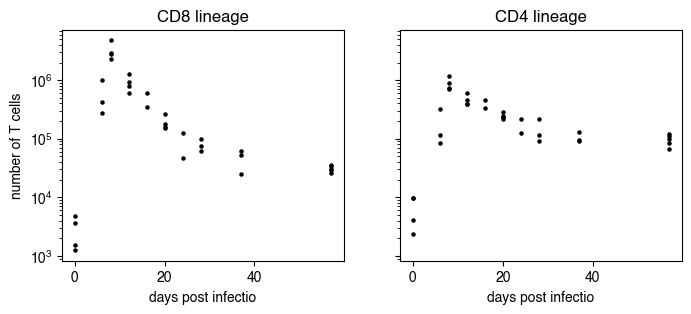

In [2]:
with open(f"../data/CD8_counts_Aug23.pkl", 'rb') as f:
    cell_counts_CD8 = pickle.load(f)

with open(f"../data/CD4_counts_Aug23.pkl", 'rb') as f:
    cell_counts_CD4 = pickle.load(f)


incl = cell_counts_CD8["include"]

days = cell_counts_CD8["DPI"][incl]
Ns_CD8 = cell_counts_CD8["CD44+CD11a+_CD8"][incl]
Ns_CD4 = cell_counts_CD4["CD44+CD11a+_CD4_Tconv"][incl]

fig, axs = plt.subplots(1, 2, figsize = (8,3), sharex = True, sharey = True)

ax = axs[0]
ax.scatter(days, Ns_CD8, s=5, color='k')
ax.set_ylabel("number of T cells")
ax.set_title("CD8 lineage")

ax = axs[1]
ax.scatter(days, Ns_CD4, s=5, color='k')
ax.set_title("CD4 lineage")

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel("days post infectio")

### Compile the Stan model

and define a function to fit the Stan model to one of the T cell count timeseries.
We first have to temoce the day 0 and day 6 time points to avoid the expansion phase.

In [3]:
sm = cmdstanpy.CmdStanModel(stan_file="../scdynsys/stan_models/cellcounts-only.stan")

T0 = 8 ## initial time
C = 1 ## number of populations

tX_CD8 = [(t, x) for t, x in zip(days, Ns_CD8) if t >= T0]
tX_CD8.sort()

tX_CD4 = [(t, x) for t, x in zip(days, Ns_CD4) if t >= T0]
tX_CD4.sort()

scaling = 1e6

def fit_stan_model(C, inhom, tX, T0):
    Nc = len(tX)
    Tc = [t for t, x in tX]
    TotalCounts = np.array([x for t, x in tX]) / scaling

    ## find unique time points and indices of these points for all observations
    Tunique = sorted(list(set(Tc)))
    Idxc = [Tunique.index(t) + 1 for t in Tc]

    ## grid for simulation
    Nsim = 100
    Tsim = np.linspace(T0, np.max(Tunique), Nsim)
    
    stan_data = {
        "N" : len(Tunique),
        "T" : Tunique,
        "T0" : T0,
        "Nc" : Nc,
        "Idxc" : Idxc,
        "C" : C,
        "TotalCounts" : TotalCounts,
        "Nsim" : Nsim,
        "Tsim" : Tsim,
        ## options
        "individual_u" : 0, ## 0 = false, 1 = true
        "eta_nonzero" : 1 if inhom else 0,
        "u_nonzero" : 1 if inhom else 0
    }

    inits = {
        "rho" : np.linspace(-0.07, -0.03, C),
        "eta" : np.full(C, -0.01),
        "u" : 0.05,
        "logX0" : np.full(C, 0.0),
        "sigma_c" : 0.5,
    }
    
    sam = sm.sample(
        data=stan_data, 
        inits=inits, 
        iter_warmup=2000,
        iter_sampling=2000,
        step_size=0.01,
        refresh=10,
        chains=4,
        adapt_delta=0.99,
        max_treedepth=15,
        show_progress=False
    )
    
    return sam, stan_data

### Not fit 3 models to 2 datasets
i.e. 6 Stan runs.

We have to choose high `adapt_delta` and `max_treedepth` to avoid divergent transitions in the 1 compartment inhomogeneous model for the CD4 data. The others converge OK with default settings.

In [4]:
# CD8
print("fitting models to CD8 data")
sam0, dd0 = fit_stan_model(1, False, tX_CD8, T0) ## 1 compartment, homogeneous
sam2, dd2 = fit_stan_model(2, False, tX_CD8, T0) ## 2 compartment, homogeneous
sam1, dd1 = fit_stan_model(1, True, tX_CD8, T0) ## 1 compartment, inhomogeneous

# CD4
print("fitting models to CD4 data")
sam0_CD4, dd0_CD4 = fit_stan_model(1, False, tX_CD4, T0) ## 1 compartment, homogeneous
sam2_CD4, dd2_CD4 = fit_stan_model(2, False, tX_CD4, T0) ## 2 compartment, homogeneous
sam1_CD4, dd1_CD4 = fit_stan_model(1, True, tX_CD4, T0) ## 1 compartment, inhomogeneous

16:37:55 - cmdstanpy - INFO - CmdStan start processing
16:37:55 - cmdstanpy - INFO - Chain [1] start processing
16:37:55 - cmdstanpy - INFO - Chain [2] start processing
16:37:55 - cmdstanpy - INFO - Chain [3] start processing
16:37:55 - cmdstanpy - INFO - Chain [4] start processing


fitting models to CD8 data


16:37:57 - cmdstanpy - INFO - Chain [2] done processing
16:37:57 - cmdstanpy - INFO - Chain [4] done processing
16:37:57 - cmdstanpy - INFO - Chain [3] done processing
16:37:57 - cmdstanpy - INFO - Chain [1] done processing
16:37:57 - cmdstanpy - INFO - CmdStan start processing
16:37:57 - cmdstanpy - INFO - Chain [1] start processing
16:37:57 - cmdstanpy - INFO - Chain [2] start processing
16:37:57 - cmdstanpy - INFO - Chain [3] start processing
16:37:57 - cmdstanpy - INFO - Chain [4] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing
16:38:04 - cmdstanpy - INFO - Chain [4] done processing
16:38:04 - cmdstanpy - INFO - Chain [3] done processing
16:38:05 - cmdstanpy - INFO - Chain [2] done processing
16:38:05 - cmdstanpy - INFO - CmdStan start processing
16:38:05 - cmdstanpy - INFO - Chain [1] start processing
16:38:05 - cmdstanpy - INFO - Chain [2] start processing
16:38:05 - cmdstanpy - INFO - Chain [3] start processing
16:38:05 - cmdstanpy - INFO - Chain [4] sta

fitting models to CD4 data


16:38:21 - cmdstanpy - INFO - Chain [3] done processing
16:38:21 - cmdstanpy - INFO - Chain [4] done processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing
16:38:21 - cmdstanpy - INFO - Chain [2] done processing
16:38:22 - cmdstanpy - INFO - CmdStan start processing
16:38:22 - cmdstanpy - INFO - Chain [1] start processing
16:38:22 - cmdstanpy - INFO - Chain [2] start processing
16:38:22 - cmdstanpy - INFO - Chain [3] start processing
16:38:22 - cmdstanpy - INFO - Chain [4] start processing
16:38:32 - cmdstanpy - INFO - Chain [1] done processing
16:38:32 - cmdstanpy - INFO - Chain [2] done processing
16:38:32 - cmdstanpy - INFO - Chain [4] done processing
16:38:34 - cmdstanpy - INFO - Chain [3] done processing
16:38:34 - cmdstanpy - INFO - CmdStan start processing
16:38:34 - cmdstanpy - INFO - Chain [1] start processing
16:38:34 - cmdstanpy - INFO - Chain [2] start processing
16:38:34 - cmdstanpy - INFO - Chain [3] start processing
16:38:34 - cmdstanpy - INFO - Chain [4] sta

### Plot model fits

combine model fits in a figure for the SI.

Text(0.5, 1.0, 'Model I-2')

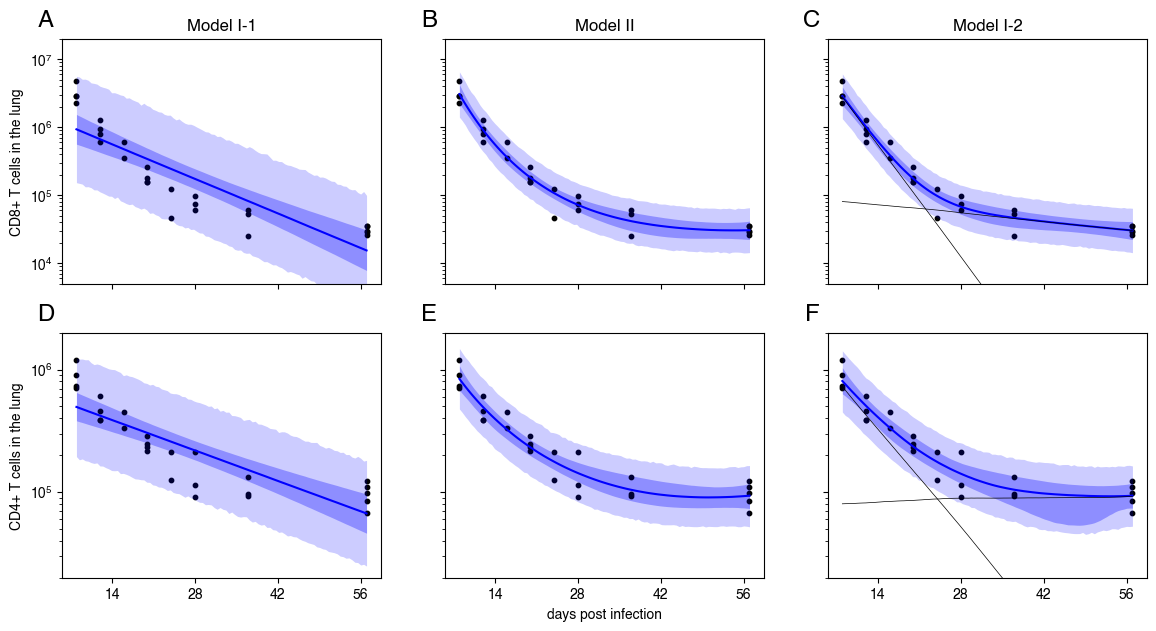

In [5]:
def plot_fits(ax, sam, C, dd):
    freqs = sam.stan_variable("freqs")
    
    ## total number of cells
    counts = sam.stan_variable("counts") * scaling
    counts_sim = sam.stan_variable("counts_sim") * scaling

    ## get some data for plotting from the stan_data dict
    Tsim = dd["Tsim"]
    TotalCounts = dd["TotalCounts"]
    Tunique = dd["T"]
    Idxc = np.array(dd["Idxc"]) # indices in unique times (this is legacy stuff)
    Tc = np.array(Tunique)[Idxc-1] # NB: base 1 to base 0 indexing  
    
    ## plot prediction
    lc, mc, hc = np.percentile(counts, axis=0, q=[2.5, 50, 97.5])
    ax.plot(Tsim, mc, color='blue')
    ax.fill_between(Tsim, lc, hc, alpha=0.3, color='blue', linewidth=0)
    ## plot data
    ax.scatter(Tc, TotalCounts * scaling, s=10, color='k')
    ## plot simulations
    l, u = np.percentile(counts_sim, q=[2.5, 97.5], axis=0)
    ax.fill_between(Tsim, l, u, color='blue', linewidth=0, alpha=0.2)
    
    if C > 1:
        for i in range(C):
            ## plot prediction
            lf, mf, hf = np.percentile(freqs[:,i,:], axis=0, q=[2.5, 50, 97.5])
            ax.plot(Tsim, mc * mf, color='k', linewidth=0.5)
            #ax.fill_between(Tsim, lf, hf, alpha=0.3, linewidth=0, color=color[i])
            #ax.set_yscale('log')
    
    ax.set_yscale('log')
    ax.set_xticks([14,28,42,56])

    
fig, axs = plt.subplots(2, 3, figsize=(14,7), sharex=True, sharey='row')

plot_fits(axs[0,0], sam0, 1, dd0) ## log-linear
plot_fits(axs[0,1], sam1, 1, dd1) ## single compartment, time-dependent
plot_fits(axs[0,2], sam2, 2, dd2) ## 2 compartments, time-homogeneous

plot_fits(axs[1,0], sam0_CD4, 1, dd0_CD4) ## log-linear
plot_fits(axs[1,1], sam1_CD4, 1, dd1_CD4) ## single compartment, time-dependent
plot_fits(axs[1,2], sam2_CD4, 2, dd2_CD4) ## 2 compartments, time-homogeneous


axs[0,0].set_ylim(5e3, 2e7)
axs[1,0].set_ylim(2e4, 2e6)

axs[1,1].set_xlabel("days post infection")
axs[0,0].set_ylabel(f"CD8+ T cells in the lung")
axs[1,0].set_ylabel(f"CD4+ T cells in the lung")

fig.align_ylabels()


for ax, lab in zip(axs.flat, 'ABCDEF'):
    ax.text(-0.05, 1.05, lab, transform=ax.transAxes, fontsize='xx-large', ha='center')

axs[0,0].set_title("Model I-1")
axs[0,1].set_title("Model II")
axs[0,2].set_title("Model I-2")

#fig.savefig(f"../results/FigureCountsOnlyFit.pdf", bbox_inches='tight')

### Nest, we use the `loo` function from arviz to compare models

in addition to the `compare` function.

In [6]:
def compare_models(sam0, sam1, sam2):
    asam0 = arviz.from_cmdstanpy(sam0, log_likelihood="log_lik")
    loo0 = arviz.loo(asam0, pointwise=True)
    asam1 = arviz.from_cmdstanpy(sam1, log_likelihood="log_lik")
    loo1 = arviz.loo(asam1, pointwise=True)
    asam2 = arviz.from_cmdstanpy(sam2, log_likelihood="log_lik")
    loo2 = arviz.loo(asam2, pointwise=True)

    comp = arviz.compare(
        {
            "M0" : asam0,
            "M1" : asam1,
            "M2" : asam2,
        },
        method="bb-pseudo-bma",
    )
    return(comp)
    
comp = compare_models(sam0, sam1, sam2)

print("=============== CD8 model comparison ================")
print(comp)

comp_CD4 = compare_models(sam0_CD4, sam1_CD4, sam2_CD4)

print("=============== CD4 model comparison ================")
print(comp_CD4)

=============== CD8 model comparison ================
    rank   elpd_loo     p_loo  elpd_diff        weight        se       dse  \
M2     0  32.733356  4.431045   0.000000  5.368573e-01  8.905951  0.000000   
M1     1  32.516870  4.556592   0.216486  4.631427e-01  8.897644  1.532458   
M0     2   8.322995  2.381782  24.410361  3.011944e-09  9.008542  3.195669   

    warning scale  
M2    False   log  
M1    False   log  
M0    False   log  
=============== CD4 model comparison ================
    rank   elpd_loo     p_loo  elpd_diff    weight        se       dse  \
M1     0  36.123202  4.059844   0.000000  0.619968  4.763154  0.000000   
M2     1  35.597357  4.374637   0.525845  0.380008  4.852208  0.538749   
M0     2  21.346771  2.635065  14.776432  0.000025  5.113431  2.949289   

    warning scale  
M1    False   log  
M2    False   log  
M0    False   log  


### Extract some parameter estimates and credible intervals

* specifically, $\sigma$ and $u$. The parameter $\sigma$ tells us something about the goodness of fit (altough we can also see thois from the posterior predictive check)
* for the bi-phasic decay model, show the decay rates


In [7]:
## parameter estimates

parnames = ["u", "sigma_c"]
transf = {
    "u" :lambda x : np.log(2)/x,
    "sigma_c" : lambda x : x,
}
print("=============== CD8 ===============")
for i, sam in enumerate([sam0, sam1, sam2]):
    for pn in parnames:
        est = transf[pn](sam.stan_variable(pn))
        l, m, h = np.percentile(est, q=[2.5, 50, 97.5])
        print(f"M{i} {pn} {m:0.2f} [{l:0.2f},{h:0.2f}]")

print("=============== CD4 ===============")
for i, sam in enumerate([sam0_CD4, sam1_CD4, sam2_CD4]):
    for pn in parnames:
        est = transf[pn](sam.stan_variable(pn))
        l, m, h = np.percentile(est, q=[2.5, 50, 97.5])
        print(f"M{i} {pn} {m:0.2f} [{l:0.2f},{h:0.2f}]")


# for the bi-phasic decay model, show the decay rates

print("========= loss rates biphasic model ==========")

est = sam2.stan_variable("rho")

for i in range(2):
    l, m, h = np.percentile(est[:,i], q=[2.5, 50, 97.5])
    print(f"M2 rho_{i} {m:0.3f} [{l:0.3f},{h:0.3f}]")

=============== CD8 ===============
M0 u 1.02 [0.30,21.20]
M0 sigma_c 0.86 [0.67,1.15]
M1 u 10.91 [5.47,57.75]
M1 sigma_c 0.34 [0.26,0.47]
M2 u 1.03 [0.31,28.30]
M2 sigma_c 0.34 [0.26,0.47]
=============== CD4 ===============
M0 u 1.01 [0.31,23.18]
M0 sigma_c 0.45 [0.35,0.61]
M1 u 20.17 [3.83,276.35]
M1 sigma_c 0.25 [0.19,0.36]
M2 u 1.02 [0.32,18.95]
M2 sigma_c 0.26 [0.19,0.36]
========= loss rates biphasic model ==========
M2 rho_0 -0.271 [-0.346,-0.214]
M2 rho_1 -0.020 [-0.039,0.004]
